In [5]:
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm, inv
import numpy as np

In [1]:
# Take minimum error for all positive and negative x
def min_error(x_hat, x_star):
    errors = []
    for x in x_hat:
            error_positive = np.linalg.norm(x_star - x)
            error_negative = np.linalg.norm(-1*x_star - x)
            errors.append(min(error_positive, error_negative))
    return errors

# Returns the convergence count for errors for a set of test parameters
def convergence_counts(errors, parameter, error_threshold = 1e-8):
    zero_error = {}
    for i in range(len(errors)):
        zero_error[parameter[i]] = 0
        for error in errors[i]:
            zero_error[parameter[i]] += error[-1] < error_threshold
    return zero_error

In [2]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_subspace_threshold(y, A, r, alpha=0, niter = 500):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    threshold = int(alpha * n)

    # Spectral initialization
    Y = (1 / n) * (A @ np.diag(y) @ A.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)  
    x[0] = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]

    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered 
        x_tilde = C_sqrt @ x[iter - 1]
        
        # Subspace
        S,_ = np.linalg.qr(np.random.normal(size = (d, r)))
        
        # Hessian
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x)*n))
        h = np.linalg.solve(S.T @ hessian @ S, -S.T @ gradient)

        x_tilde = x_tilde + S @ h

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-15:
                return x[:iter]
        
    return x

In [3]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_spectral(y, A, niter = 30, tol = 1e-15):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    
    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A 
   
    # Spectral initialization
    Y = (1 / n) * (A_tilde @ np.diag(y) @ A_tilde.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)  
    x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
    x[0] = C_inv @ x_tilde
                
    # Hessian
    hessian = (A_tilde @ A_tilde.T) / n
    inv_hessian = inv(hessian)

    # Descent
    for iter in range(1, niter):
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))

        x_tilde -= gradient @ inv_hessian

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<tol:
                return x[:iter]
        
    return x

In [154]:
int(250 * np.log(250)) 

1380

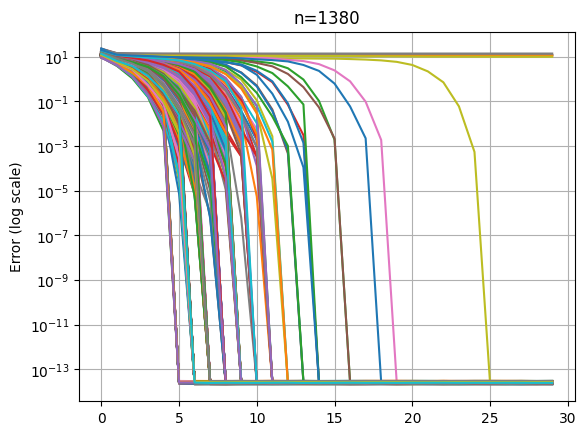

{1380: 995}

In [157]:
d = 250
n_vals = np.arange(1, 5)*100
n_vals = [1380]
errors = []

for n in n_vals:
    n_error = []
    for j in range(1, 1001):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_spectral(y, A)
        error = min_error(x_hat, x)
        n_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(n_error)
    plt.title(f'n={n}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.savefig(f'Convergence at n={n}.png') 
    plt.show()
convergence_counts(errors, n_vals)

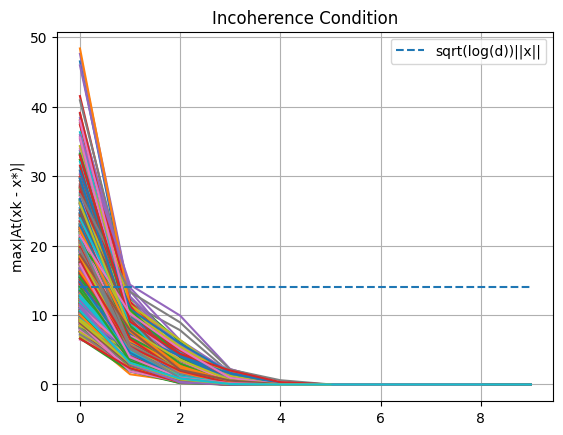

In [53]:
n = 400
d = 50
n_vals = np.arange(1, 5)*100

for j in range(1, 1001):  
    # Generate vectors
    x = np.ones(d)
    A = np.random.randn(d, n)
    y = np.square(A.T @ x)
        
    # Run the algorithm
    x_hat = bwgd_spectral(y, A, niter=10)

    # Incoherence condition
    at_x = []
    for x_k in x_hat:
        at_x.append(np.max(np.abs(A.T @ (x_k - x_hat[-1]))))
    
    # Plot results
    if min_error(x_hat, np.ones(d))[-1]>1e-8:
        plt.plot(at_x, label="wrong convergence")
    else:
        plt.plot(at_x)


plt.title("Incoherence Condition")
plt.ylabel("max|At(xk - x*)|")
plt.plot([np.sqrt(np.log(d)) * np.linalg.norm(np.ones(d))]*10, label = "sqrt(log(d))||x||", linestyle='--')
plt.legend()
plt.grid(True)
plt.savefig('Incoherence condition.png') 

100%|█████████████████████████████████████████████████████████| 21/21 [04:06<00:00, 11.72s/it]


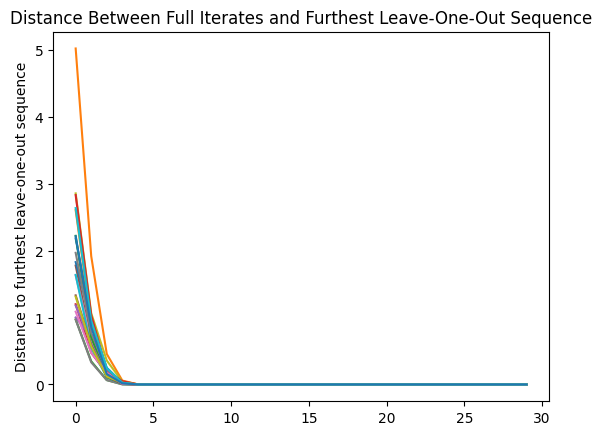

In [54]:
from tqdm import tqdm
d = 50 
n = 500
runs = 21
niter = 30

distances = np.zeros((runs, niter))

for j in tqdm(range(runs)):
    x = np.ones(d)
    A = np.random.randn(d, n)
    y = np.square(A.T @ x)
    
    x_hat = bwgd_spectral(y, A, tol=1e-30)
    
    elementwise_distances = np.zeros(niter)
    for l in range(n):
        A_l = np.delete(A, l, axis=1)
        y_l = np.delete(y, l)
        
        x_hat_l = bwgd_spectral(y_l, A_l, tol=1e-30)

        for i in range(len(x_hat)):
            dif1 = np.linalg.norm(x_hat[i] - x_hat_l[i])
            dif2 = np.linalg.norm(x_hat[i] + x_hat_l[i])
            dif = min(dif1, dif2)
            if elementwise_distances[i] < dif:
                elementwise_distances[i] = dif
    
    distances[j] = elementwise_distances
    plt.plot(distances[j])
plt.ylabel('Distance to furthest leave-one-out sequence')
plt.title('Distance Between Full Iterates and Furthest Leave-One-Out Sequence')
plt.show()


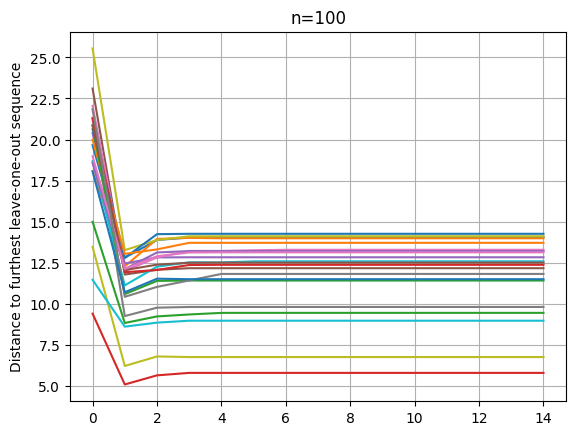

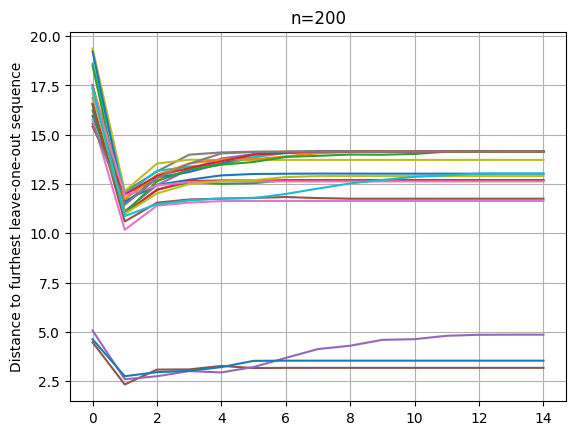

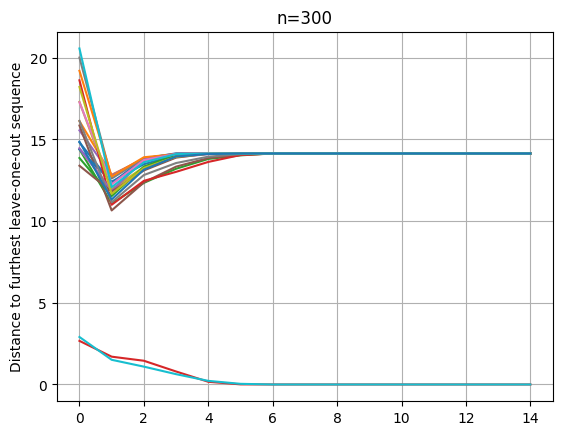

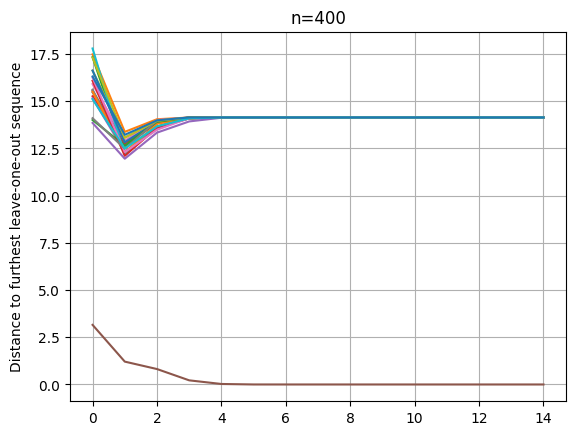

In [42]:
from tqdm import tqdm
d = 50 
runs = 21
niter = 15
n_vals = np.arange(1, 5)*100

for n in n_vals:
    distances = np.zeros((runs, niter))
    
    for j in range(runs):
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        x_hat = bwgd_spectral(y, A, niter=niter, tol=1e-30)
        
        elementwise_distances = np.zeros(niter)
        for l in range(n):
            A_l = np.delete(A, l, axis=1)
            y_l = np.delete(y, l)
            
            x_hat_l = bwgd_spectral(y_l, A_l, niter = niter, tol=1e-30)
    
            for i in range(len(x_hat)):
                dif = np.linalg.norm(x_hat[i] - x_hat_l[i])
                #dif2 = np.linalg.norm(x_hat[i] + x_hat_l[i])
                #dif = min(dif1, dif2)
                if elementwise_distances[i] < dif:
                    elementwise_distances[i] = dif
        
        distances[j] = elementwise_distances
        plt.plot(distances[j])
    plt.ylabel('Distance to furthest leave-one-out sequence')
    plt.title(f'n={n}')
    plt.grid()
    plt.show()

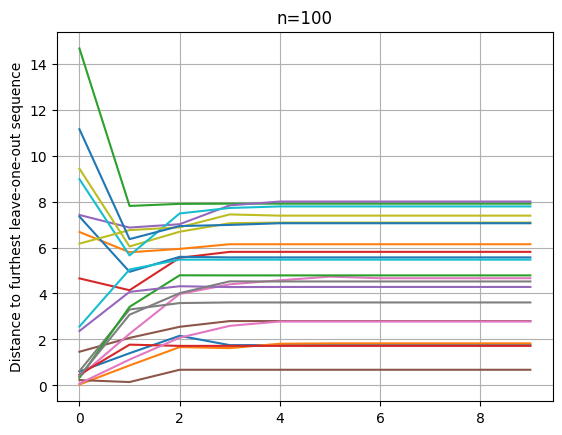

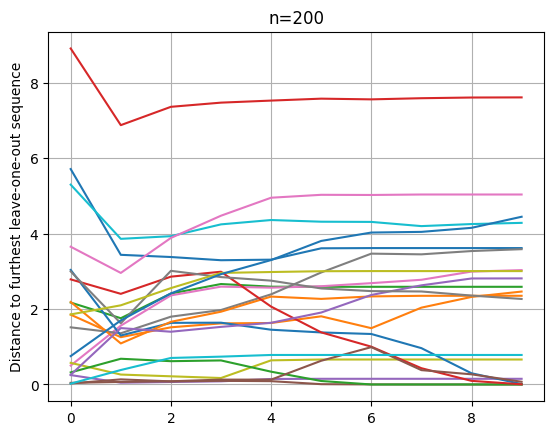

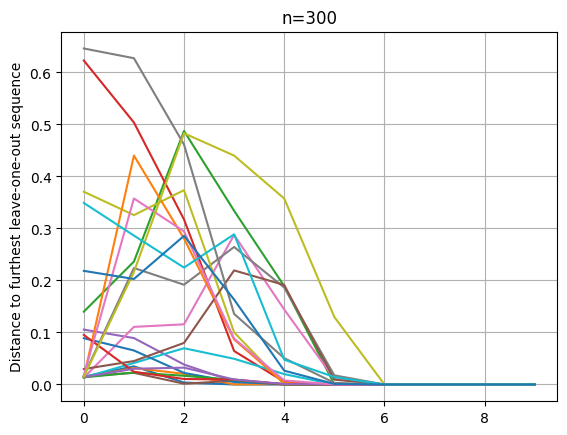

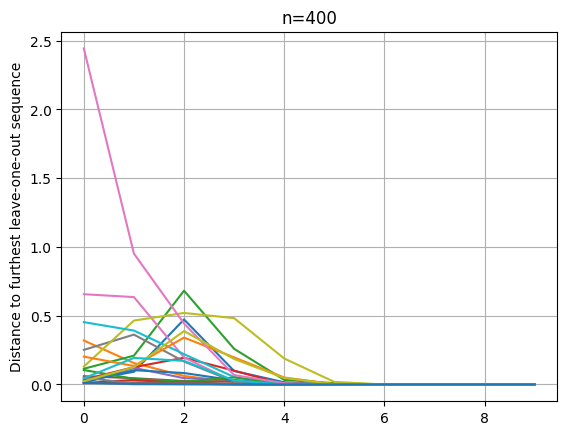

In [41]:
from tqdm import tqdm
d = 50 
runs = 21
niter = 10
n_vals = np.arange(1, 5)*100

for n in n_vals:
    distances = np.zeros((runs, niter))
    
    for j in range(runs):
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        x_hat = bwgd_spectral(y, A, niter=niter, tol=1e-30)
        
        elementwise_distances = np.zeros(niter)
        for l in range(n):
            A_l = np.delete(A, l, axis=1)
            y_l = np.delete(y, l)
            
            x_hat_l = bwgd_spectral(y_l, A_l, niter = niter, tol=1e-30)

            if elementwise_distances[-1] < np.linalg.norm(x_hat[-1] - x_hat_l[-1]):
                for i in range(len(x_hat)):
                    dif1 = np.linalg.norm(x_hat[i] - x_hat_l[i])
                    dif2 = np.linalg.norm(x_hat[i] + x_hat_l[i])
                    elementwise_distances[i] = min(dif1, dif2)
        
        distances[j] = elementwise_distances
        plt.plot(distances[j])
    plt.ylabel('Distance to furthest leave-one-out sequence')
    plt.title(f'n={n}')
    plt.grid()
    plt.show()

**Phase transition**

In [10]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_threshold(y, A, alpha=0, niter = 50):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    threshold = int(alpha * n)

    # Spectral initialization
    Y = (1 / n) * (A @ np.diag(y) @ A.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)  
    x[0] = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]

    for iter in range(1, niter):
        # Find indices for smallest |AtX|
        sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
        indices = sorted_indices[threshold:]

        # Discard the selected indices
        A_filtered = A.T[indices].T.copy()
        y_filtered = y[indices].copy()

        # Covariance matrix transform
        C = A_filtered @ A_filtered.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A_filtered

        if iter == 1:
            Y = (1 / n) * (A_tilde @ np.diag(y_filtered) @ A_tilde.T)
            eigenvals, eigenvects = np.linalg.eigh(Y)
            index = np.argmax(eigenvals)  
            x_tilde = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]
            x[0] = C_inv @ x_tilde
                
        # Hessian
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y_filtered) * At_x / (np.abs(At_x)*n))
        h = np.linalg.solve(hessian, gradient)

        x_tilde -= h

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-15:
                return x[:iter]
        
    return x

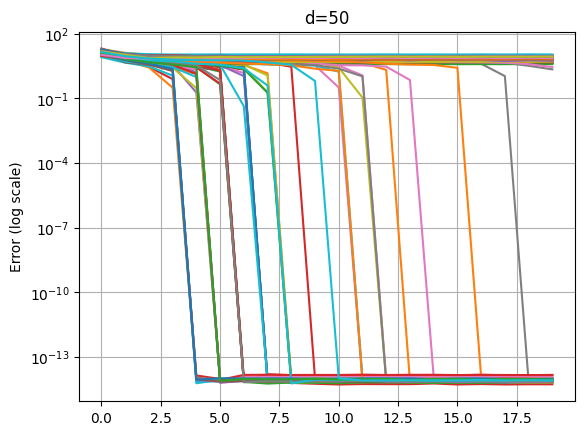

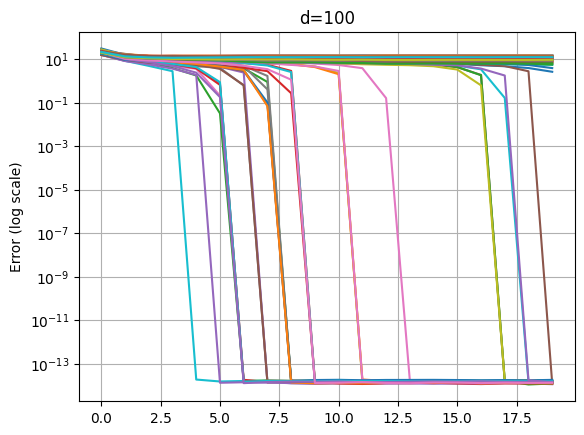

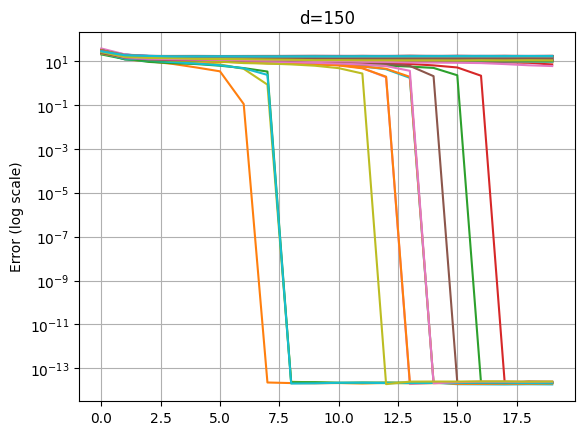


KeyboardInterrupt



Error in callback <function flush_figures at 0x000001685BF0BBA0> (for post_execute):



KeyboardInterrupt



In [11]:
# Plot for d
d_vals = [50, 100, 150, 200, 250, 300]
errors = []

for d in d_vals:
    n_error = []
    for j in range(1, 101):  
        n = d*4
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_threshold(y, A,alpha=0.4, niter=20)
        error = min_error(x_hat, x)
        n_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(n_error)
    plt.title(f'd={d}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.savefig(f'Convergence at n={n}.png') 
    plt.show()
convergence_counts(errors, d_vals)

In [143]:
from tqdm import tqdm
from numpy.linalg import LinAlgError  

def phase_transition(d_values, alphas, niter=100):
    # Matrix for convergence in d_values x alphas
    convergence = np.zeros((len(d_values), len(alphas)))

    for i, d in tqdm(list(enumerate(d_values))):  # Iterate over dimensions
        n = int(d * np.log(d)) 
        x_true = np.ones(d)  # True solution

        for j, alpha in enumerate(alphas):
            converged = 0
            for _ in range(niter):
                # Generate random samples A and response y
                A = np.random.randn(d, n)
                y = (A.T @ x_true) ** 2  

                try:
                    # Run algorithm
                    x_hat = bwgd_threshold(y, A, alpha)  # Ensure this function is defined

                    # Check for convergence
                    if min_error(x_hat, x_true)[-1] < 1e-12:
                        converged += 1 

                except LinAlgError:  # Catch singular matrix errors and treat as non-converging
                    pass  

            convergence[i, j] = converged

    return convergence

In [145]:
d_values = np.array([50, 100, 150, 200, 250, 300, 350, 400])  
alphas = np.arange(0, 8) * 0.1  
convergence = phase_transition(d_values, alphas)

100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [14:05:38<00:00, 6342.31s/it]


In [151]:
convergence

array([[ 64.,  77.,  81.,  77.,  63.,  35.,  10.,  50.],
       [ 95.,  97.,  93.,  82.,  68.,  43.,  17.,   6.],
       [ 98.,  97.,  93.,  84.,  54.,  38.,  16.,   5.],
       [100.,  99.,  98.,  85.,  65.,  36.,  18.,   6.],
       [100., 100.,  99.,  80.,  59.,  46.,  25.,   6.],
       [100.,  99.,  96.,  81.,  58.,  39.,  30.,   3.],
       [100., 100.,  96.,  83.,  47.,  33.,  38.,   9.],
       [100., 100.,  95.,  74.,  55.,  39.,  31.,  13.]])

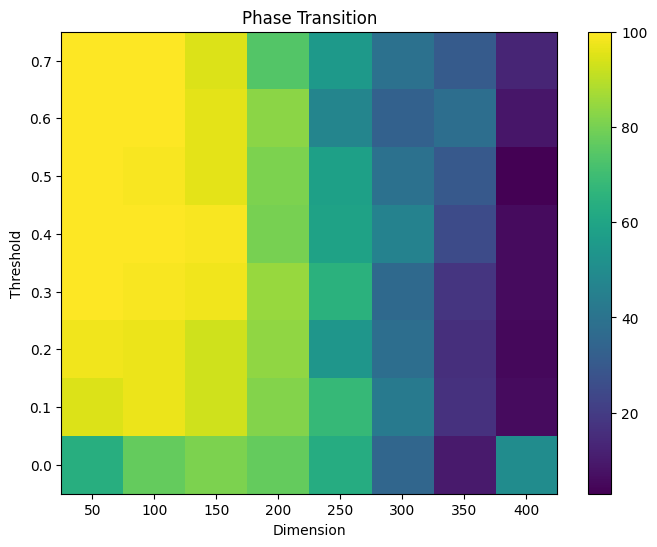

In [150]:
# Plot
plt.figure(figsize=(8, 6))
im = plt.imshow(convergence, aspect='auto', cmap='viridis', origin='lower')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(len(d_values)), labels=d_values)
plt.yticks(ticks=np.arange(len(alphas)), labels=np.round(alphas, 2))

plt.xlabel("Dimension")
plt.ylabel("Threshold")
plt.title("Phase Transition")
plt.colorbar(im)

plt.show()

**Permenant Thresholding**

We only need some ai to keep us in the correct region. From previous experiments, I know that some ai are never thresholded, and thus are very reliable. Also, as long as n = d*2, solution could be found. So we can permenantly remove ai until the final solution is found

Additionally, in paper they do random initialization of true x, while we fix them at 1. Might that be affecting results?

In [398]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_threshold_permenant(y, A, alpha=0, niter = 50, ratio =1.2):
    d, n = A.shape 
    x = np.zeros((niter, d))  
    threshold = int(alpha * n)

    # Spectral initialization
    Y = (1 / n) * (A @ np.diag(y) @ A.T)
    eigenvals, eigenvects = np.linalg.eigh(Y)
    index = np.argmax(eigenvals)  
    x[0] = np.sqrt(eigenvals[index] / 3) * eigenvects[:, index]

    for iter in range(1, niter):
        d, n = A.shape 
        threshold = int(alpha * n)

        if n > d*ratio:
            # Find indices for smallest |AtX|
            sorted_indices = np.argsort(np.abs(A.T @ x[iter - 1]))
            indices = sorted_indices[threshold:]
    
            # Discard the selected indices
            A = A.T[indices].T.copy()
            y = y[indices].copy()

        # Covariance matrix transform
        C = A @ A.T / n
        C_sqrt = sqrtm(C)
        C_inv = np.real(inv(C_sqrt))
        A_tilde = C_inv @ A 
        x_tilde = C_sqrt @ x[iter - 1]
                
        # Hessian
        hessian = (A_tilde @ A_tilde.T) / n
        
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
        h = np.linalg.solve(hessian, gradient)

        x_tilde -= h

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-14:
            return x[:iter]
        
    return x

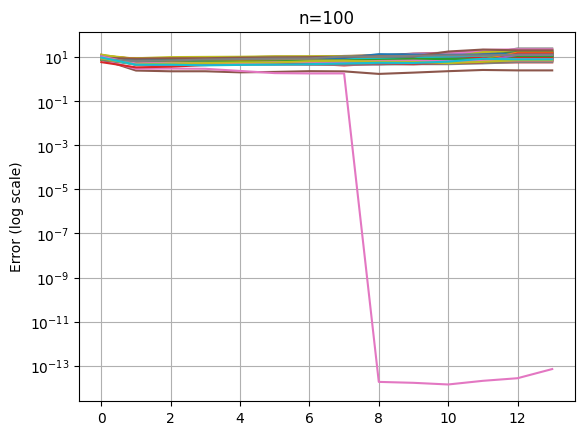

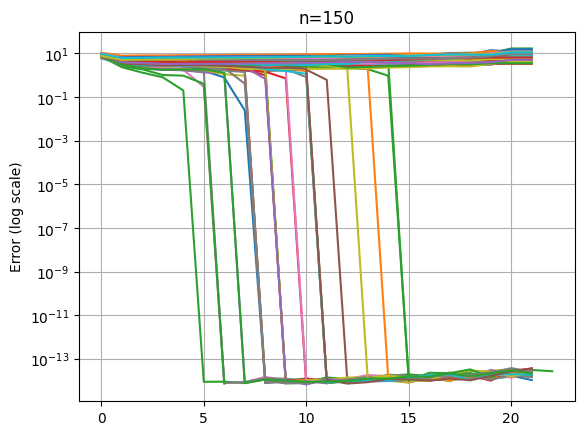

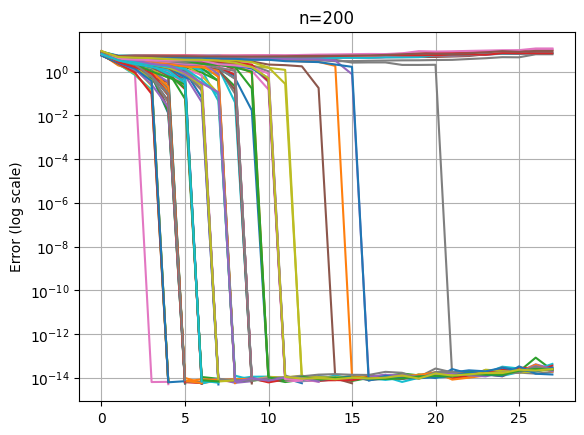

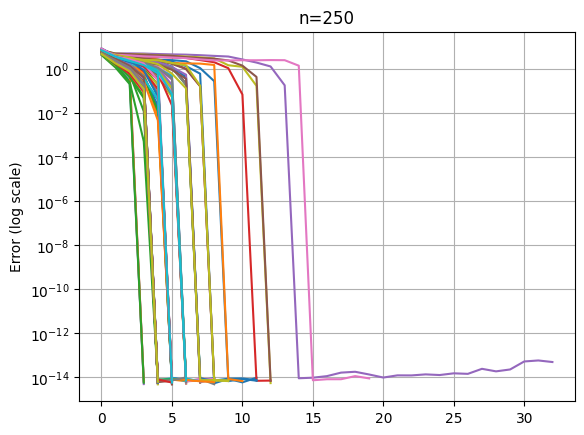

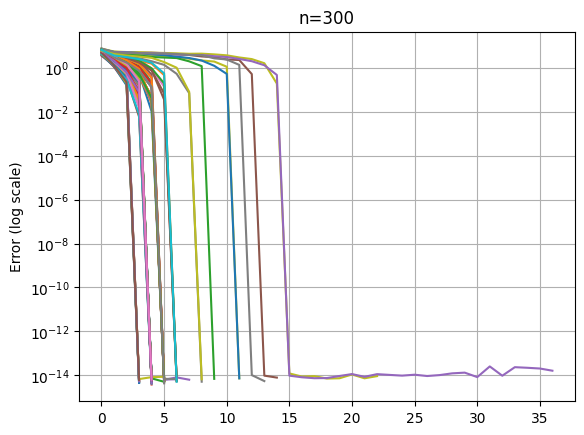

{100: 1, 150: 28, 200: 92, 250: 100, 300: 100}

In [403]:
d = 50
n_vals = [100, 150, 200, 250, 300]
errors = []

for n in n_vals:
    n_error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_threshold_permenant(y, A, alpha=0.05, niter=50)
        error = min_error(x_hat, x)
        n_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(n_error)
    plt.title(f'n={n}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.savefig(f'Convergence at n={n}.png') 
    plt.show()
convergence_counts(errors, n_vals)

In [399]:
samples = np.array([100, 150, 200, 250, 300])  
alphas = np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])  
convergence = phase_transition(samples, alphas)

5it [28:27, 341.50s/it]


array([[  0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.],
       [ 24.,  27.,  31.,  24.,  35.,  40.,  28.,  34.,  39.,  25.],
       [ 71.,  86.,  89.,  89.,  88.,  90.,  89.,  88.,  85.,  84.],
       [ 95.,  98.,  99.,  99., 100.,  99., 100.,  95.,  96., 100.],
       [100., 100., 100.,  99., 100., 100., 100.,  98.,  99., 100.]])

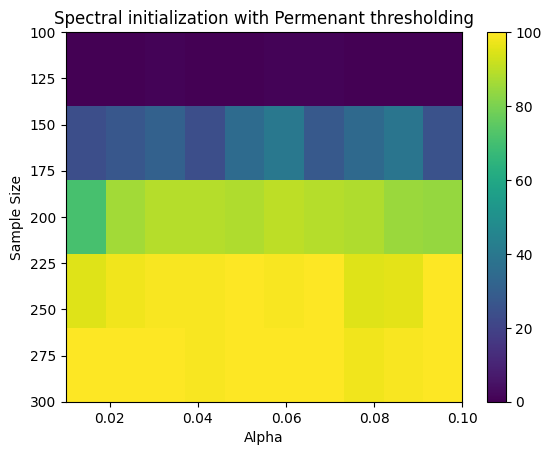

In [400]:
im = plt.imshow(convergence, extent=[alphas[0], alphas[-1], samples[-1], samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Sample Size')
plt.title('Spectral initialization with Permenant thresholding')
convergence

**Thresholding at only first iteration**

In [275]:
# Thresholding at only first iteration
samples = np.array([100, 150, 200, 250, 300])  
alphas = np.arange(0, 9) * 0.1  
convergence = phase_transition(samples, alphas)

0it [00:00, ?it/s]C:\Users\gabreu\AppData\Local\Temp\ipykernel_32532\946246735.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_32532\946246735.py:43: RuntimeWarning: overflow encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_32532\946246735.py:43: RuntimeWarning: invalid value encountered in matmul
  x[iter] = C_inv @ x_tilde
C:\Users\gabreu\AppData\Local\Temp\ipykernel_32532\946246735.py:38: RuntimeWarning: invalid value encountered in divide
  gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))
5it [03:52, 46.59s/it]


array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  5.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 64.,  42.,  22.,   9.,   3.,   2.,   0.,   2.,   0.],
       [ 93.,  92.,  83.,  65.,  48.,  18.,   2.,   6.,  22.],
       [100.,  98.,  97.,  97.,  90.,  71.,  33.,  14.,  36.]])

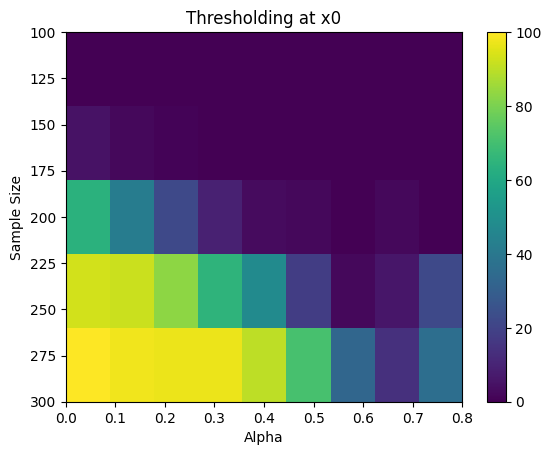

In [277]:
im = plt.imshow(convergence, extent=[alphas[0], alphas[-1], samples[-1], samples[0]], aspect='auto')
plt.colorbar()
plt.xlabel('Alpha')
plt.ylabel('Sample Size')
plt.title('Thresholding at x0')
convergence

Random Scaled Initialization

In [5]:
# Implements BWDG over a stochastic Subspace with thresholding
def bwgd_random(y, A, niter = 50):
    d, n = A.shape 
    x = np.zeros((niter, d))  

    # Initialize  x randomly
    u = np.random.randn(d)  
    u /= np.linalg.norm(u)   
    x[0] = (np.sum(y) / n) * u

    
    # Covariance matrix transform
    C = A @ A.T / n
    C_sqrt = sqrtm(C)
    C_inv = np.real(inv(C_sqrt))
    A_tilde = C_inv @ A 
    x_tilde = C_sqrt @ x[0]
                
    # Hessian
    hessian = (A_tilde @ A_tilde.T) / n
    inv_hessian = inv(hessian)

    # Descent
    for iter in range(1, niter):
        # Gradient
        At_x = A_tilde.T @ x_tilde  
        gradient = hessian @ x_tilde - A_tilde @ (np.sqrt(y) * At_x / (np.abs(At_x)*n))

        x_tilde -= gradient @ inv_hessian

        x[iter] = C_inv @ x_tilde

        if np.linalg.norm(x[iter] - x[iter-1])<1e-15:
                return x[:iter]
        
    return x

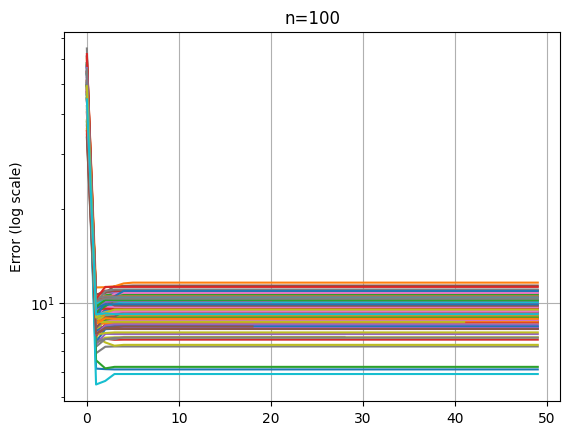

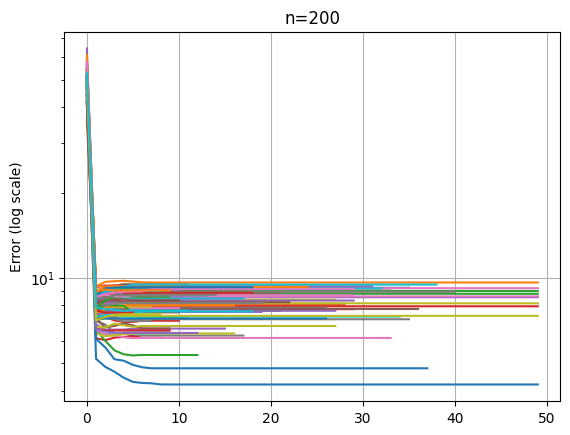

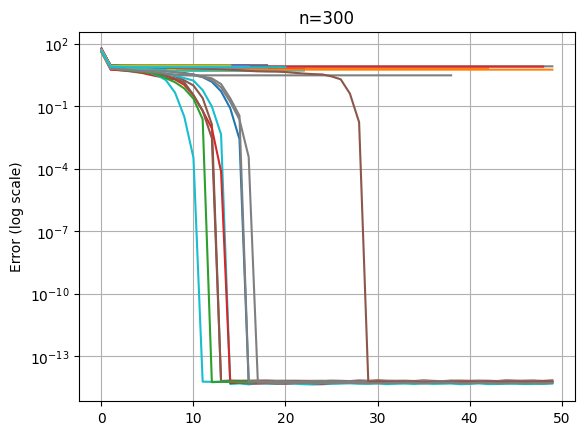

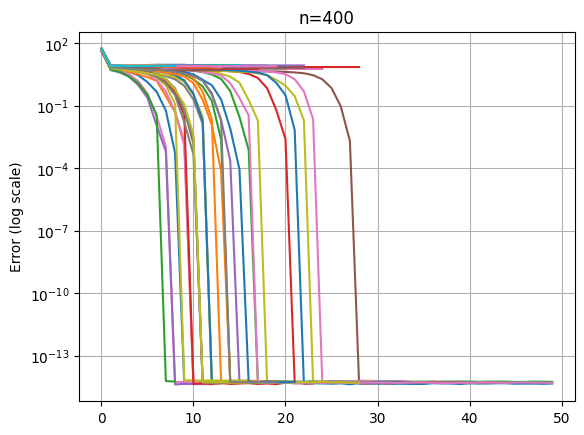

{100: 0, 200: 0, 300: 10, 400: 29}

In [9]:
d = 50
n_vals = np.arange(1, 5)*100
errors = []

for n in n_vals:
    n_error = []
    for j in range(1, 101):  
        # Generate vectors
        x = np.ones(d)
        A = np.random.randn(d, n)
        y = np.square(A.T @ x)
        
        # Run the algorithm
        x_hat = bwgd_random(y, A, niter=50)
        error = min_error(x_hat, x)
        n_error.append(error)
        
        # Plot results
        plt.plot(error)

    errors.append(n_error)
    plt.title(f'n={n}')
    plt.ylabel("Error (log scale)")
    plt.yscale('log')  
    plt.grid(True)
    plt.show()
convergence_counts(errors, n_vals)